# Notebook 03: Time Series Forecasting

This notebook forecasts Q2, Q3, and Q4 sales for watches using the data cleaned in [Notebook 1: Data Cleaning](01_data_cleaning.ipynb).

In [286]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.var import VAR

from sklearn.metrics import mean_squared_error

import random

In [287]:
df_models = pd.read_csv('../cleaned_datasets/models_quarterly_sales.csv')

In [288]:
df_proposal = pd.read_csv('../cleaned_datasets/proposal.csv')

In [289]:
df_models.columns

Index(['style_id', 'status', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022-01', '2022-02', '2022-03', '2022-04', 'qt_sales_order',
       'total_sales_2022', 'qt_on_hand', 'monthly_avg_2022', 'wholesale_price',
       'color', 'country_of_origin', 'warranty', 'band_color', 'band_material',
       'case_material', 'clasp_type', 'dial_color', 'movement_type',
       'water_resistant', 'max_cart_qty', 'retail_price', 'collection',
       'gender', 'case_size', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1',
       '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4',
       '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2', '2019Q3',
       '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2',
       '2021Q3', '2021Q4', '2022Q1'],
      dtype='object')

In [290]:
df_proposal_sales = df_proposal.merge(df_models, how='left',on='style_id')

In [291]:
y = df_proposal_sales[['style_id','2015Q1', '2015Q2', '2015Q3', '2015Q4', 
               '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1',
       '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
       '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3',
       '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1']].set_index('style_id')

In [292]:
y.sort_values(by = '2022Q1', ascending=False, inplace=True)
y.columns = pd.to_datetime(y.columns)

In [293]:
y = y.T

In [294]:
y.index = pd.DatetimeIndex(y.index, freq='infer') 

In [295]:
y.index = pd.PeriodIndex(y.index,freq='Q-OCT') 

In [296]:
y.index

PeriodIndex(['2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
             '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4',
             '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2',
             '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4',
             '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1'],
            dtype='period[Q-OCT]')

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='ES3203'>)

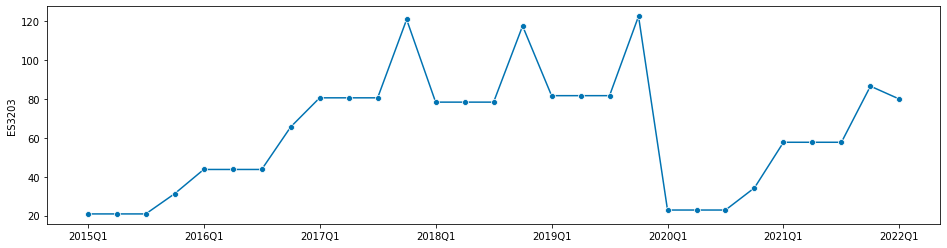

In [297]:
plot_series(y.iloc[:,0])

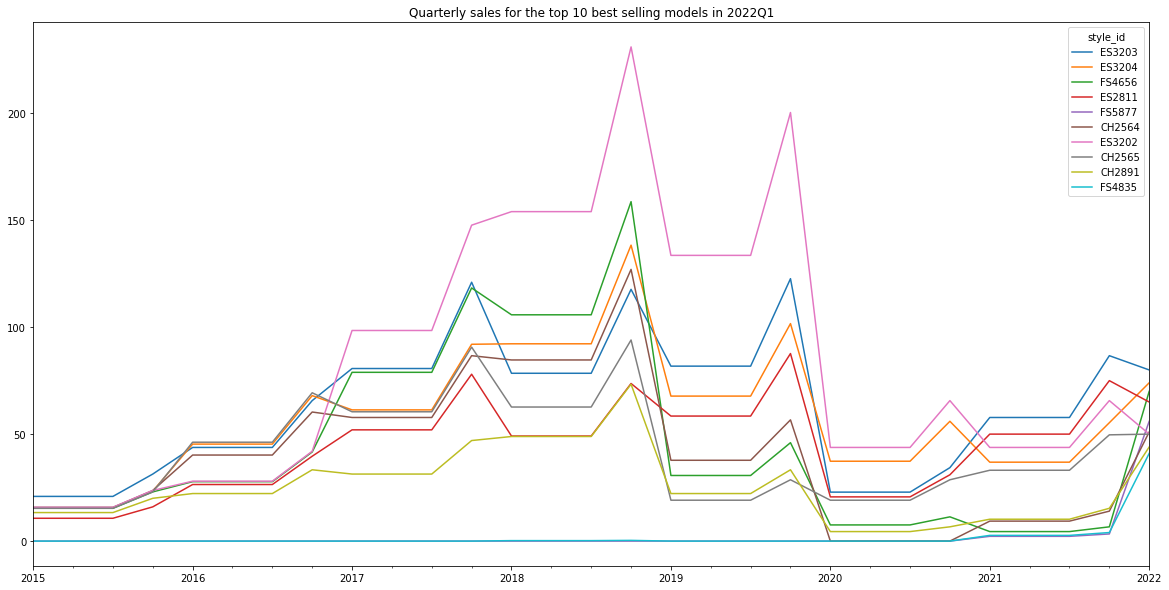

In [298]:
y.iloc[:,0:10].plot(figsize=(20,10),title='Quarterly sales for the top 10 best selling models in 2022Q1');

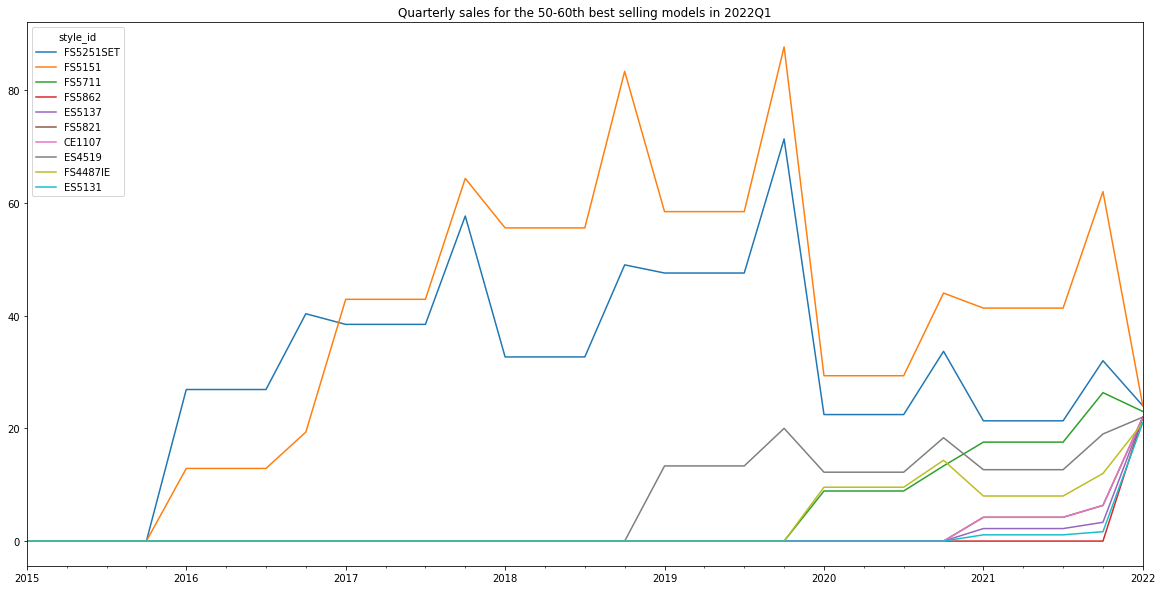

In [299]:
y.iloc[:,50:60].plot(figsize=(20,10),title='Quarterly sales for the 50-60th best selling models in 2022Q1');

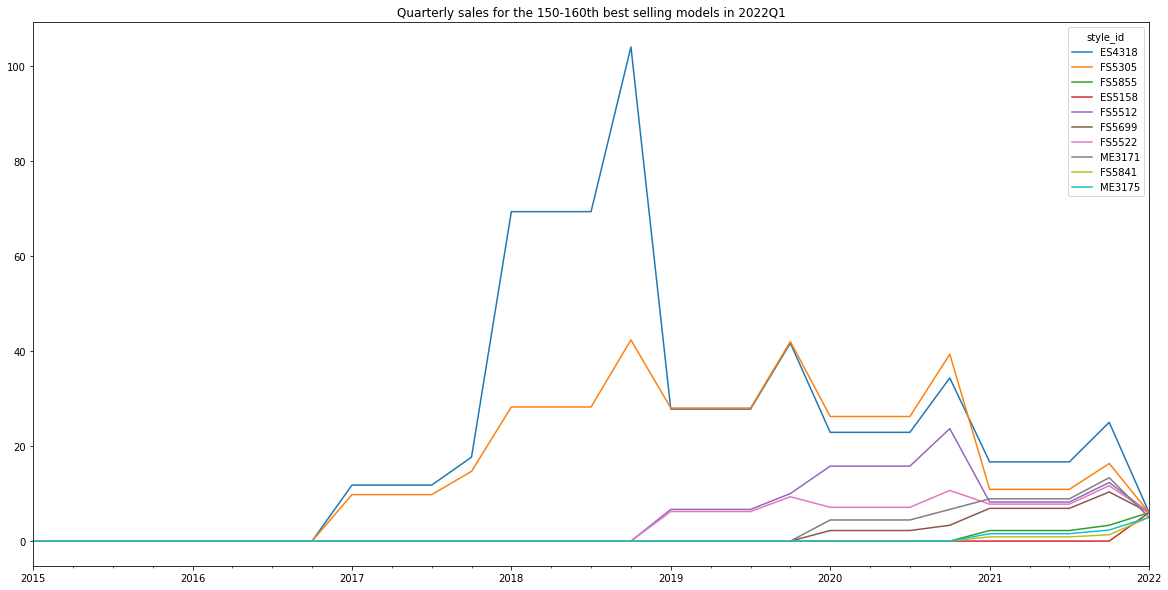

In [300]:
y.iloc[:,150:160].plot(figsize=(20,10),title='Quarterly sales for the 150-160th best selling models in 2022Q1');

#### Temporal TTS

In [301]:
y_train, y_test = temporal_train_test_split(y, test_size=1)

In [302]:
y_train.shape

(28, 265)

In [303]:
y_test.shape

(1, 265)

### Custom functions for forecasting evaluation

In [304]:
def pred_mse(y_test, preds):
    """ This function generates the mean squared error for the 2022Q2 predictions against the actual sales and all models.
    """
    return mean_squared_error(y_test.iloc[0,:], preds.iloc[0,:])

In [305]:
def plot_pred(y_train, y_test, preds):
    """ This function generates 10 plots for random models in the dataset.
    """
    for i in [random.randint(0,y_train.shape[1]) for _ in range(10)]:
        plot_series(y_train.iloc[:,i], y_test.iloc[:,i], preds.iloc[:,i], labels = ['train','test','preds']);

### Baseline model using last value

In [306]:
baseline_last = NaiveForecaster() # default strategy is last

In [307]:
baseline_last.fit(y_train)

NaiveForecaster()

In [308]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 28 entries, 2015Q1 to 2021Q4
Freq: Q-OCT
Columns: 265 entries, ES3203 to ME3220
dtypes: float64(265)
memory usage: 58.2 KB


In [309]:
pred_freq_list = [1,2,3,4]
baseline_last_preds = baseline_last.predict(pred_freq_list)

In [310]:
baseline_last_mse = pred_mse(y_test, baseline_last_preds)
baseline_last_mse

166.862893081761

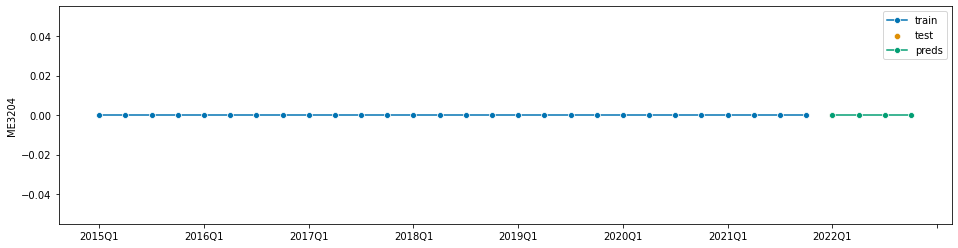

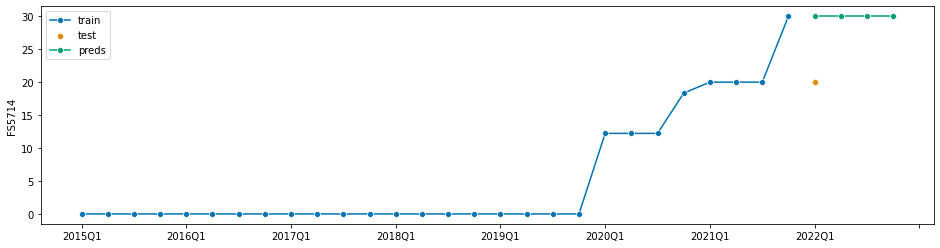

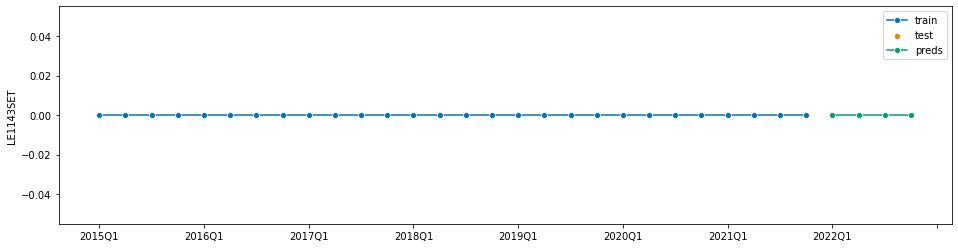

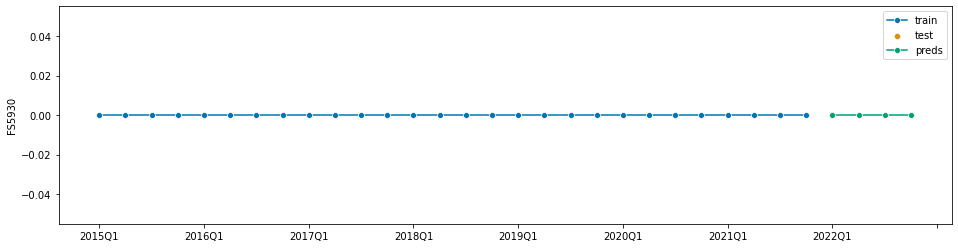

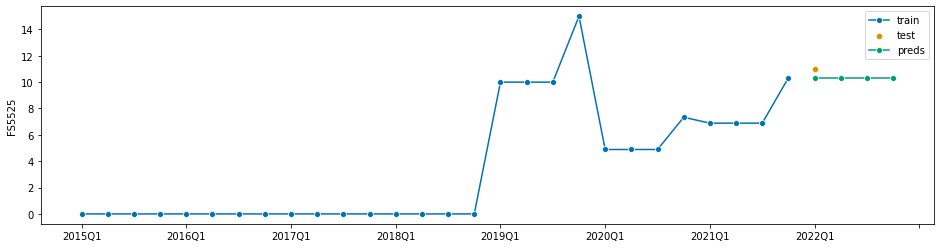

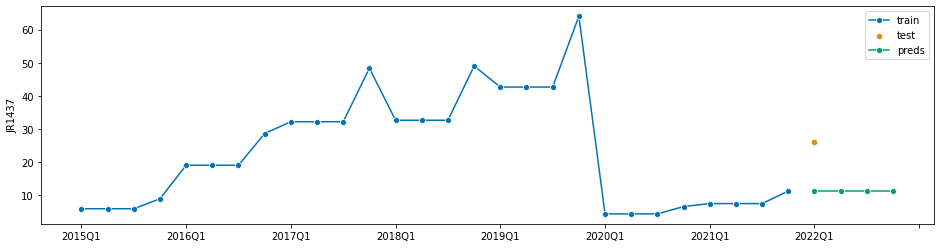

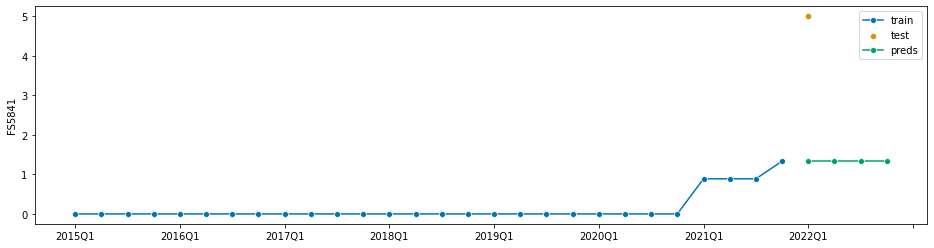

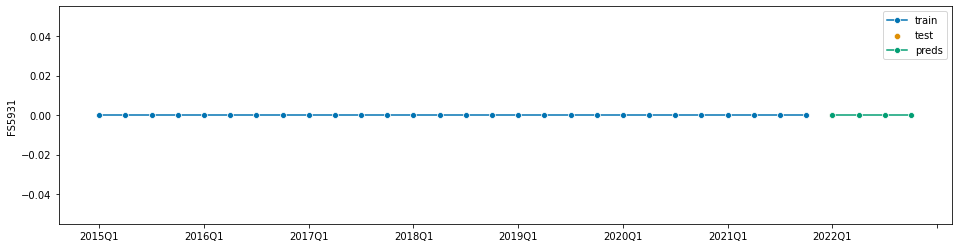

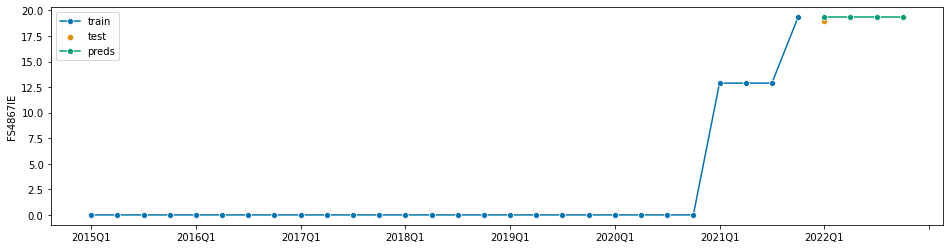

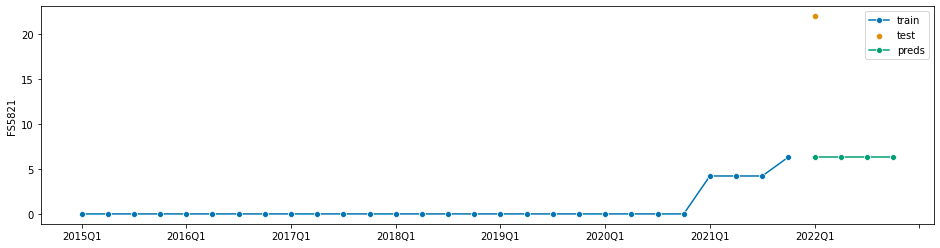

In [311]:
plot_pred(y_train, y_test, baseline_last_preds)

In [312]:
def plot_pred(y_train, y_test, preds):
    """ This function generates 10 plots for random models in the dataset.
    """
    for i in [random.randint(0,y_train.shape[1]) for _ in range(10)]:
        plot_series(y_train.iloc[:,i], y_test.iloc[:,i], preds.iloc[:,i], labels = ['train','test','preds']);

### Baseline model using drift

In [317]:
baseline_drift = NaiveForecaster(strategy='drift')
baseline_drift.fit(y_train)
baseline_drift_preds = baseline_drift.predict(pred_freq_list)
pred_mse(y_test,baseline_drift_preds)

172.04199639761927

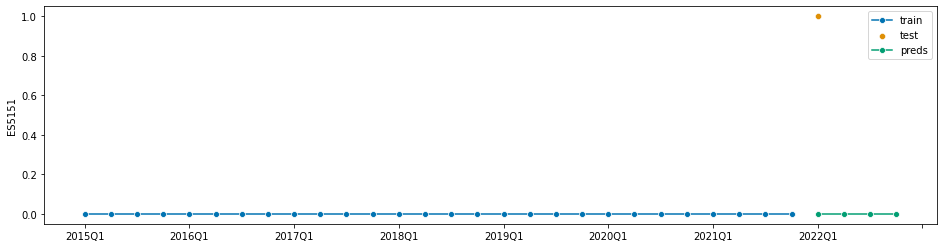

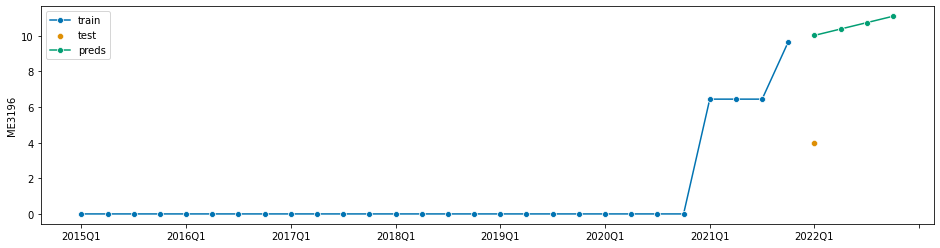

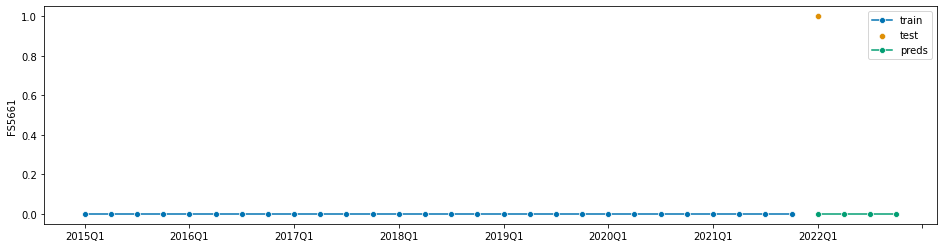

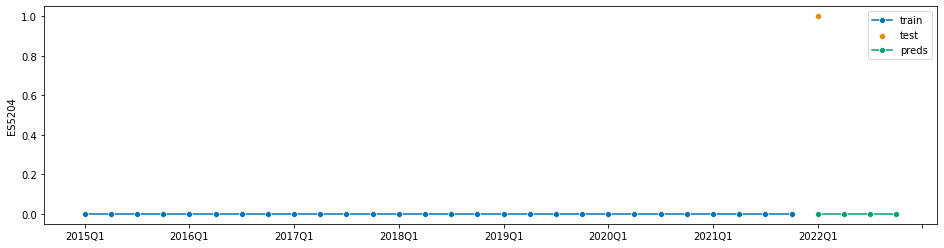

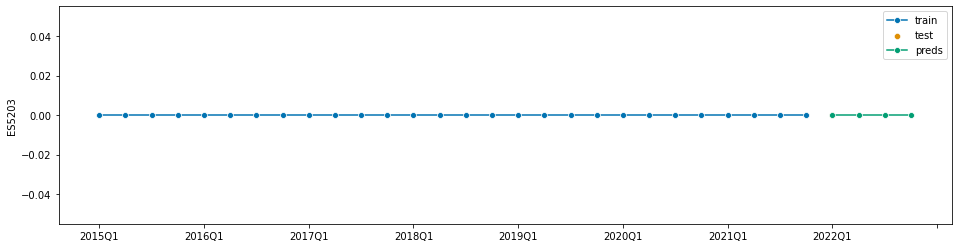

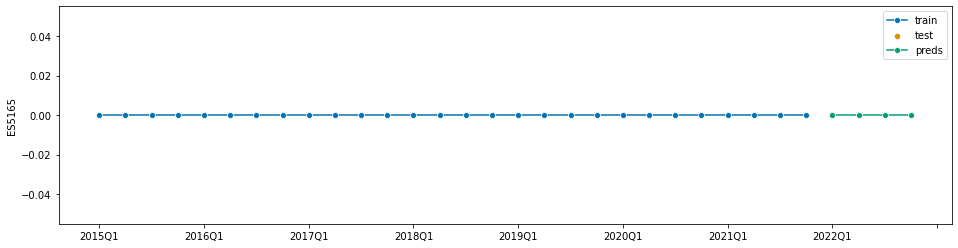

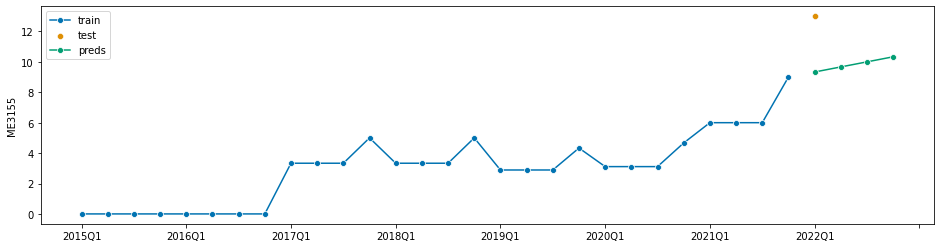

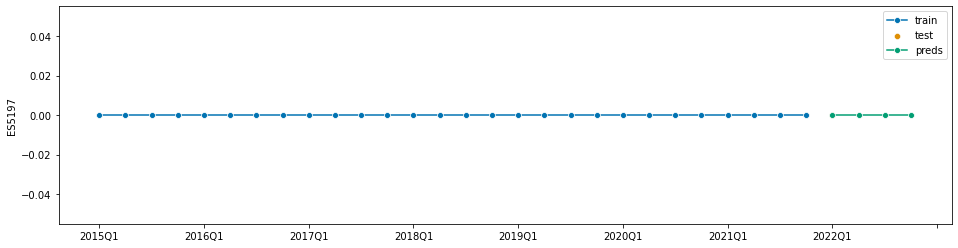

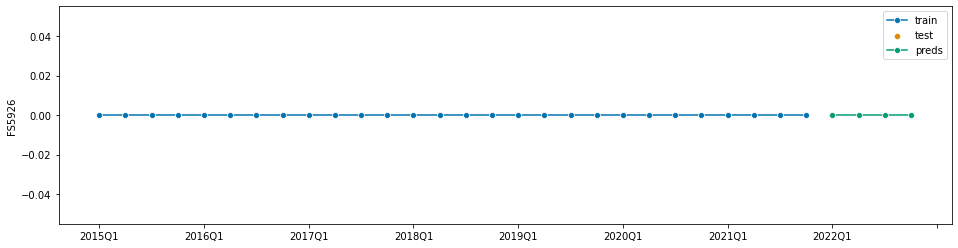

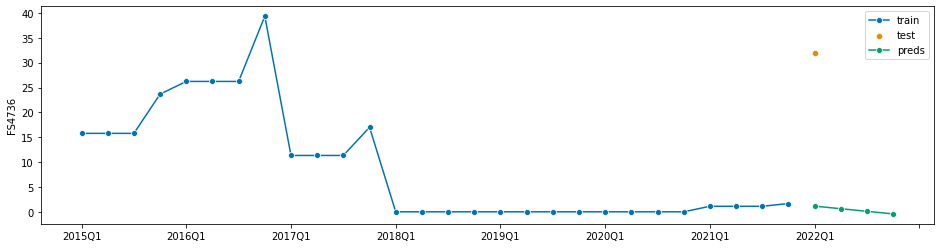

In [318]:
plot_pred(y_train,y_test,baseline_drift_preds)

### Baseline last seasonal cycle (quarterly)

In [319]:
baseline_seasonal = NaiveForecaster(strategy='last',sp=4)
baseline_seasonal.fit(y_train)
baseline_seasonal_preds = baseline_seasonal.predict(pred_freq_list)
pred_mse(y_test, baseline_seasonal_preds)

162.76799440950387

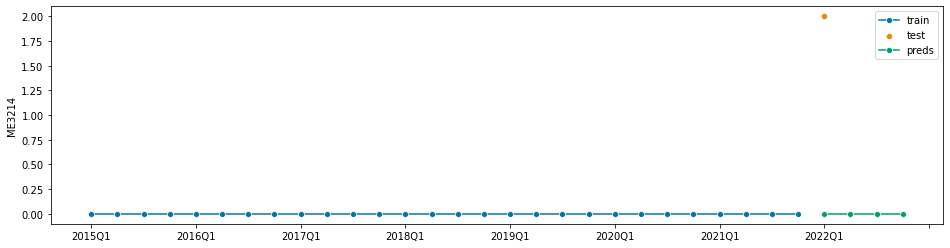

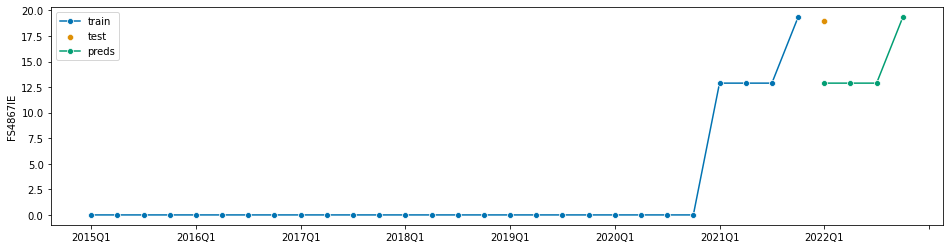

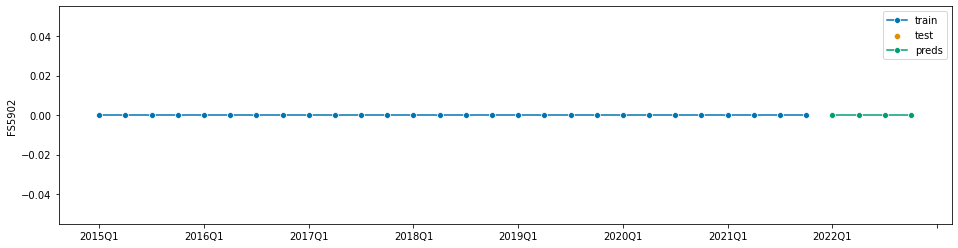

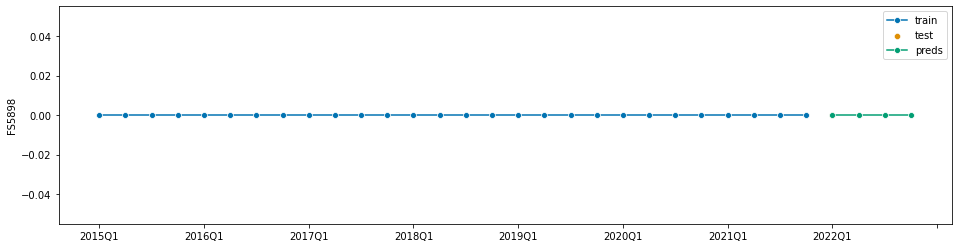

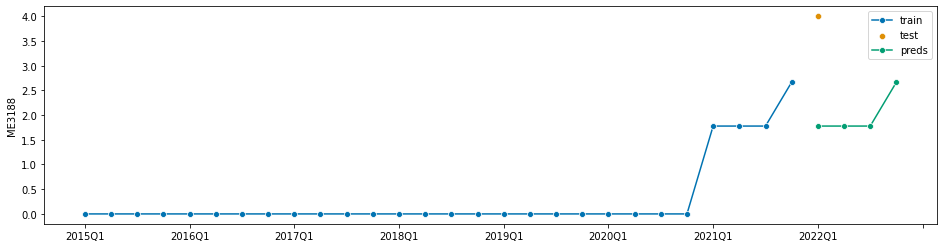

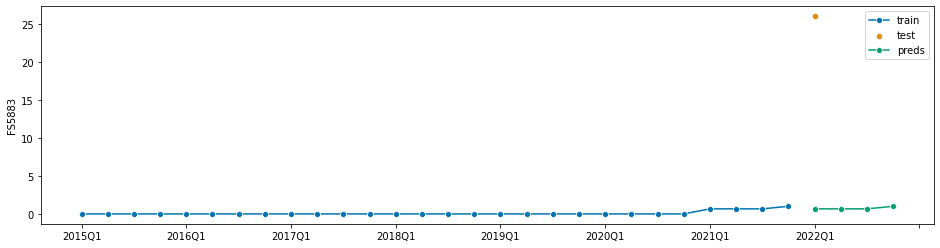

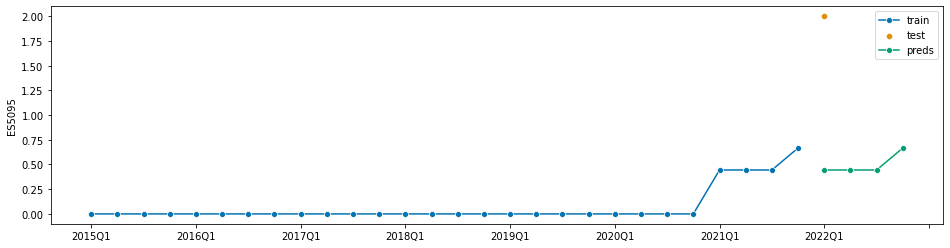

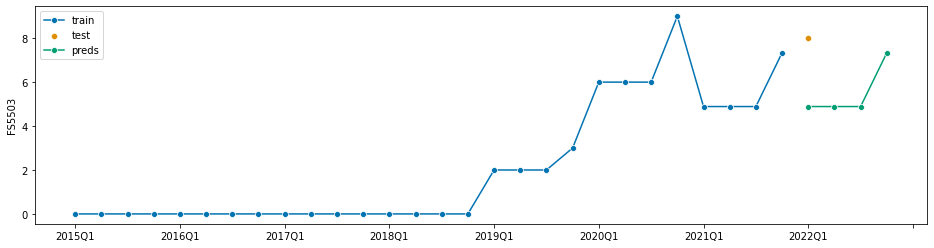

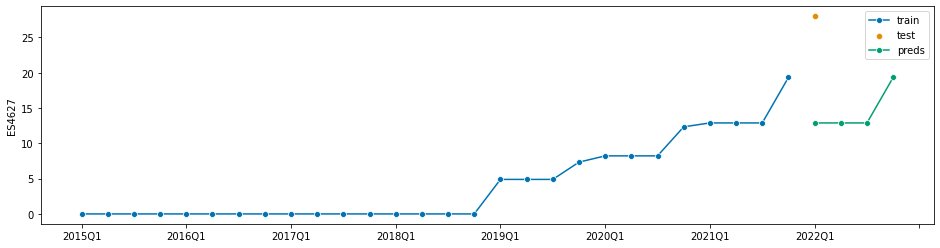

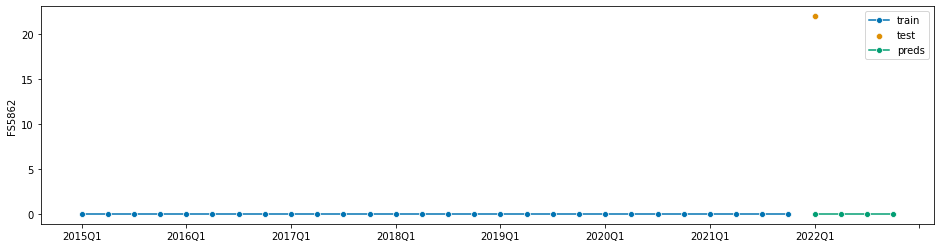

In [320]:
plot_pred(y_train, y_test, baseline_seasonal_preds)

### SARIMA

In [322]:
# # Used this to generate SARIMA predictions
# sarima_preds = pd.DataFrame()
# for model in y_train:
#     sarima_model = AutoARIMA(sp=4, trace=True)
#     print(model)
#     sarima_model.fit(y_train[model])
#     try:
#         sarima_preds[model] = sarima_model.predict(1)
#     except:
#         sarima_preds[model] = np.nan
# sarima_preds.T.to_csv('../cleaned_datasets/sarima_preds.csv')

In [326]:
sarima_preds = pd.read_csv('../cleaned_datasets/sarima_preds.csv', index_col='Unnamed: 0')

In [327]:
sarima_preds.isna().sum() # Only failed on 6, not too bad

2022Q1    6
dtype: int64

In [329]:
# Find those models which failed
model_failure_SARIMA = []
for model,failed in sarima_preds.T.isna().items():
    if failed[0]:
        model_failure_SARIMA.append(model)
model_failure_SARIMA

['FS5877', 'ES5137', 'FS5799', 'FS5855', 'FS5663', 'ES5097']

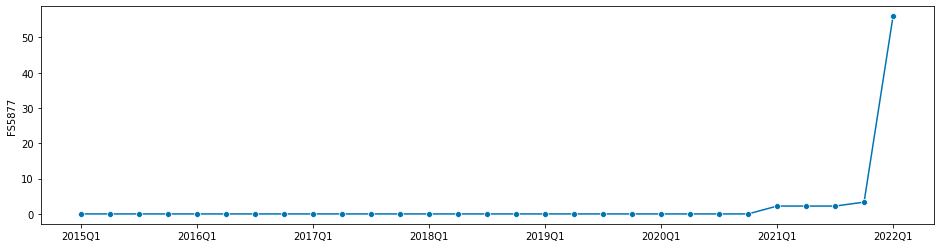

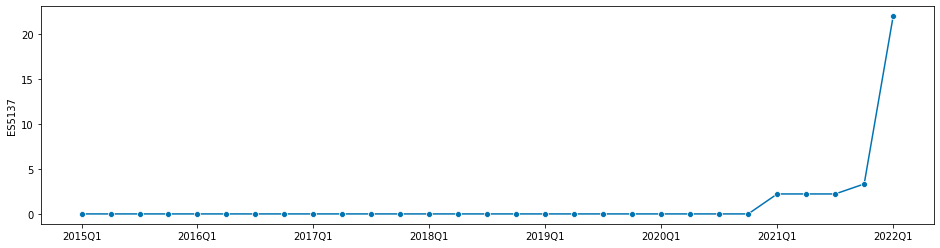

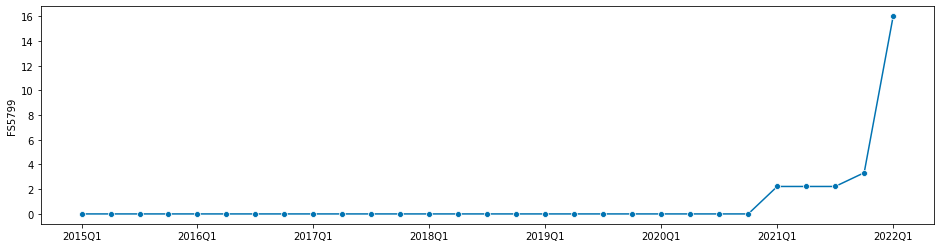

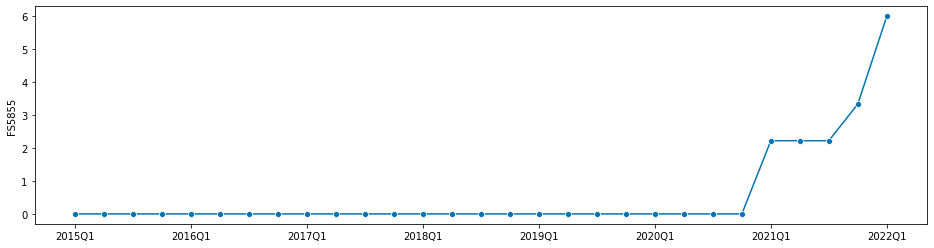

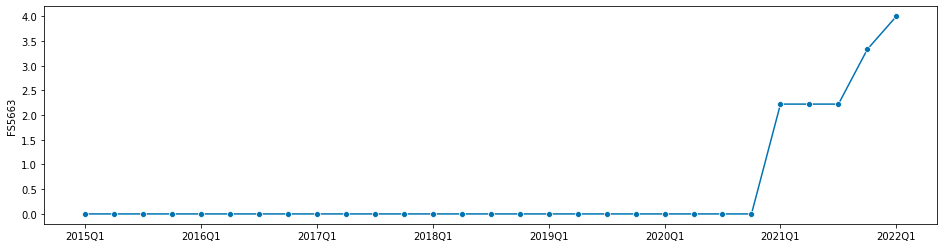

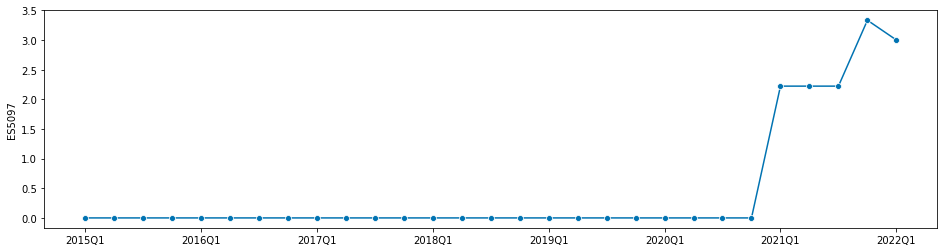

In [331]:
for model in model_failure_SARIMA:
    plot_series(y.loc[:,model])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='FS5877'>)

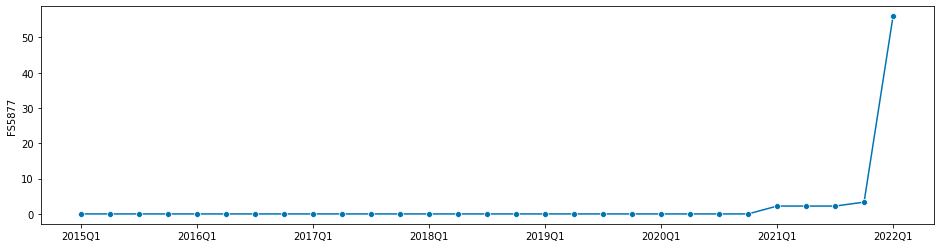

In [330]:
plot_series(y.loc[:,'FS5877'])

In [226]:
baseline_seasonal = NaiveForecaster(strategy='last',sp=4)
baseline_seasonal.fit(y_train)
baseline_seasonal_preds = baseline_seasonal.predict(pred_freq_list)
pred_mse(y_test, baseline_seasonal_preds)

162.76799440950387

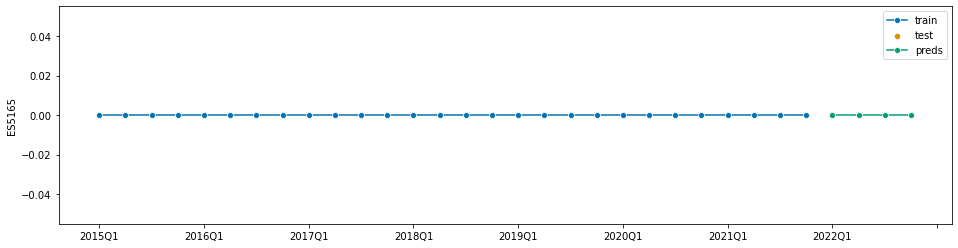

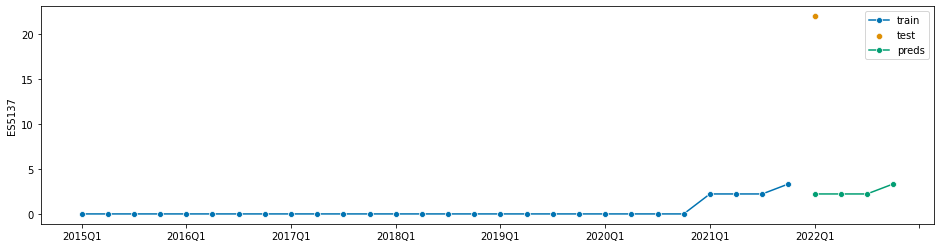

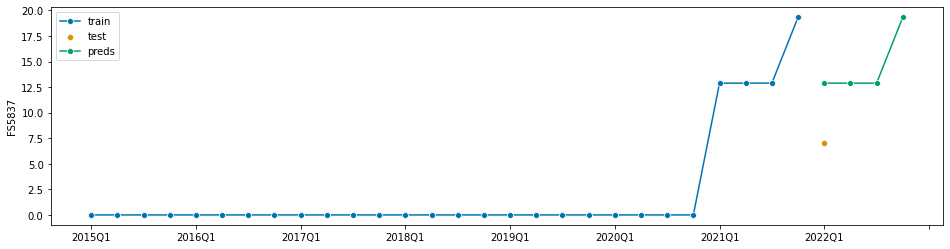

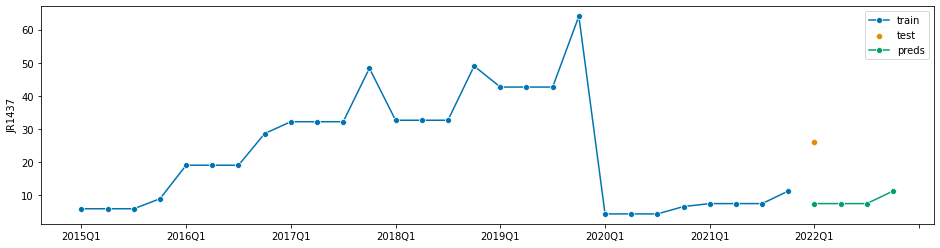

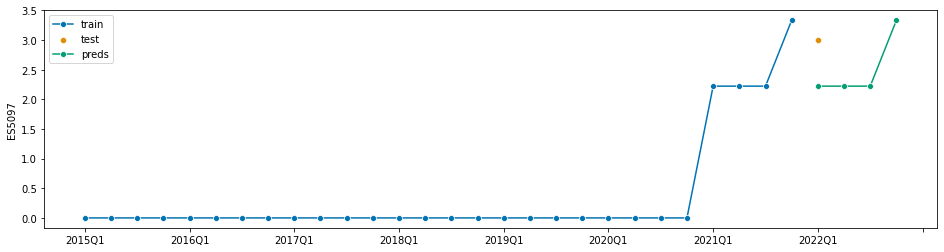

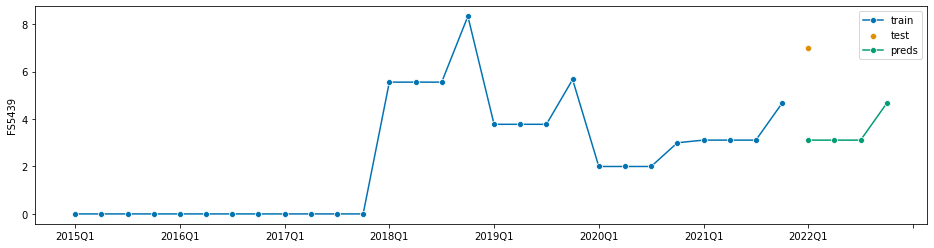

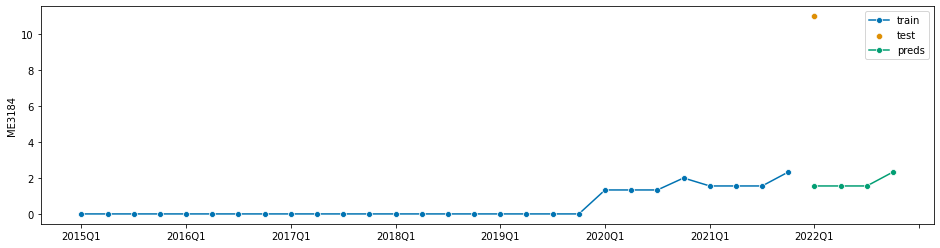

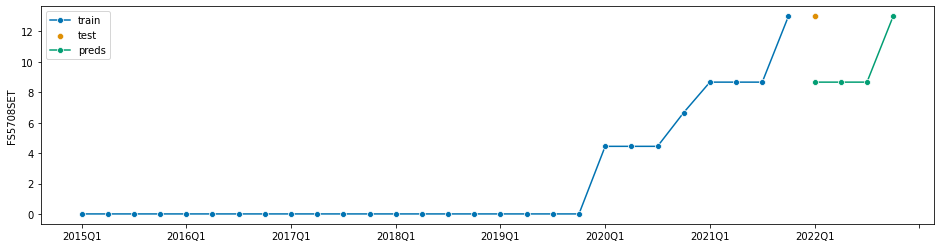

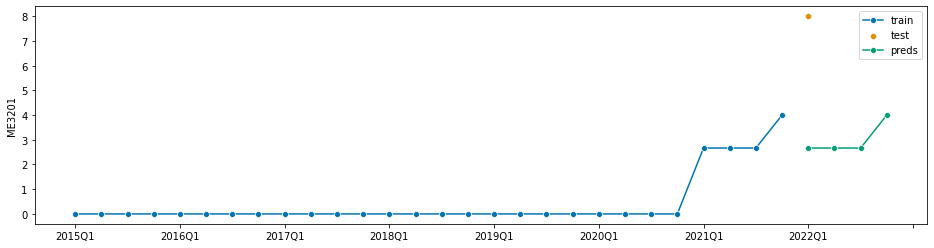

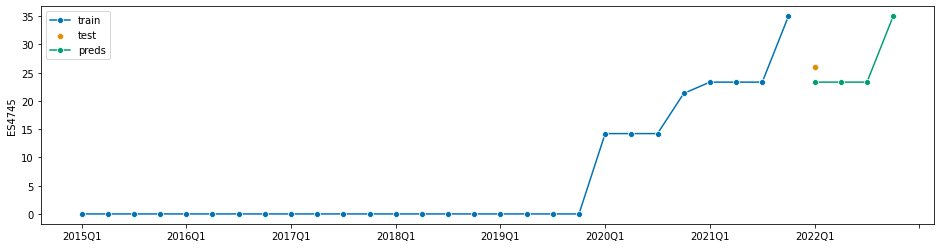

In [227]:
plot_pred(y_train, y_test, baseline_seasonal_preds)